In [39]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [42]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [43]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [44]:
df.shape

(1259, 7)

In [45]:
series = df['close'].values.reshape(-1, 1)
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [0]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

### **Approach 1 --> Predict Stock Prices**


In [48]:
# Windows of length 10, next value being the target
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


**Training an LSTM model**

In [49]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 27ms/step - loss: 0.1539 - val_loss: 0.1615
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0396
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0395
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0630
Epoch 5/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0472
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0372
Epoch 7/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 0.0422
Epoch 8/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0321
Epoch 9/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0334
Epoch 10/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0281
Epoch 11/80
20/20 

**Plotting Loss Per Iteration**

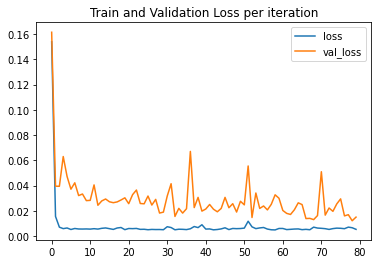

In [50]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Train and Validation Loss per iteration")
plt.legend()
plt.show()

**One-Step Forecast**

(1249, 1)


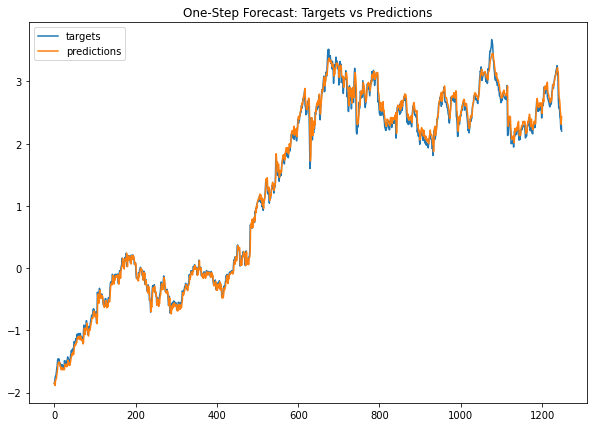

In [51]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize = (10,7))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("One-Step Forecast: Targets vs Predictions")
plt.legend()
plt.show()

**For one step forecast, this model is preforming really well. Now we'll try multi-step forecast**

**Multi-step forecast**

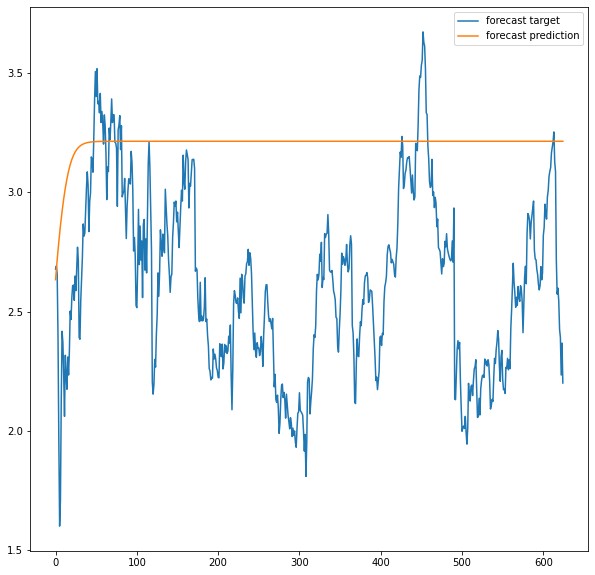

In [52]:
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.figure(figsize = (10,10))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

**For a multi-step forecast, the forecast is a straight line. The model is not predicting the next value, it's just copying the previous value that was its own output.**

### **Second Approach --> Predict Stock Returns**

**Stock Return is calculated as follows:**

(final price - initial price)/(initial price)

In [53]:
df['PrevClose'] = df['close'].shift(1) # move everything up 1
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [54]:
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


**Plot the Stock Returns Histogram**

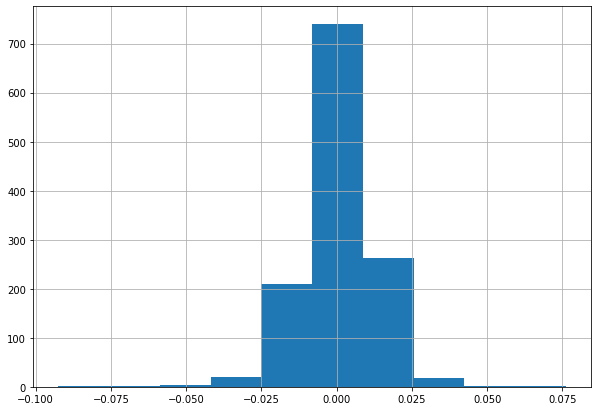

In [74]:
plt.figure(figsize = (10,7))
df['Return'].hist()
plt.show()

In [0]:
series = df['Return'].values[1:].reshape(-1, 1)

**Scale the Data**

In [0]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

**Training the LSTM model**

In [58]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) 
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [59]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 27ms/step - loss: 1.0064 - val_loss: 1.1468
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9943 - val_loss: 1.1651
Epoch 3/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9858 - val_loss: 1.1665
Epoch 4/80
20/20 [==============================] - 0s 8ms/step - loss: 1.0006 - val_loss: 1.1588
Epoch 5/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9815 - val_loss: 1.1558
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9830 - val_loss: 1.1557
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9848 - val_loss: 1.1598
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0294 - val_loss: 1.1507
Epoch 9/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9713 - val_loss: 1.1587
Epoch 10/80
20/20 [==============================] - 0s 8ms/step - loss: 1.0004 - val_loss: 1.1585
Epoch 11/80
20/20 

**Plotting Loss Per Iteration**

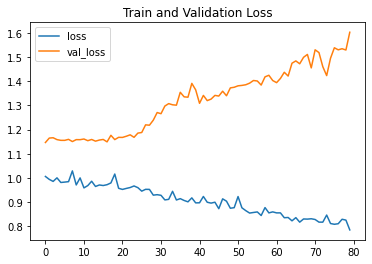

In [60]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

**One-Step Forecast of Stock Returns**

(1248, 1)


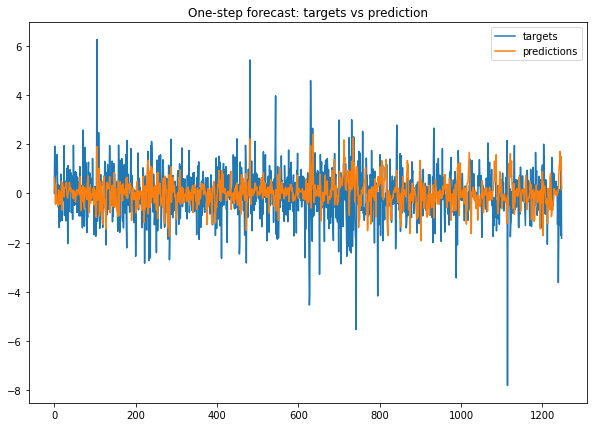

In [61]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]


plt.figure(figsize=(10,7))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("One-step forecast: targets vs prediction")
plt.legend()
plt.show()

**Multi-step Forecast**

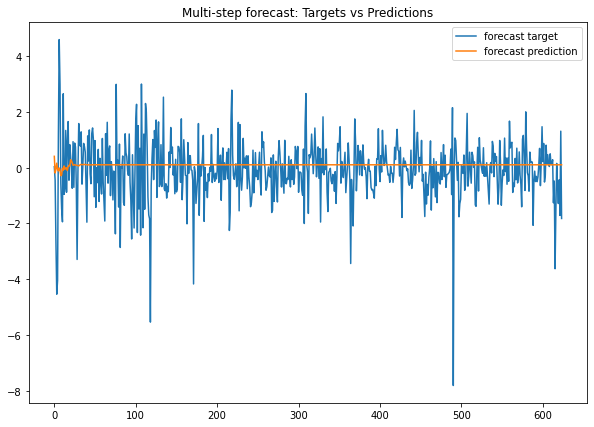

In [62]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.figure(figsize = (10, 7))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.title("Multi-step forecast: Targets vs Predictions")
plt.legend()
plt.show()

### **Third Approach**

1.   Predict whether the price will go up or down
2.   Predict whether the return will be positive or negative






In [0]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [0]:
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [0]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [0]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [0]:
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [69]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 23ms/step - loss: 0.6958 - accuracy: 0.5042 - val_loss: 0.6917 - val_accuracy: 0.5146
Epoch 2/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6923 - accuracy: 0.5077 - val_loss: 0.6951 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5137 - val_loss: 0.6921 - val_accuracy: 0.5024
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6888 - accuracy: 0.5387 - val_loss: 0.6991 - val_accuracy: 0.4854
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.5375 - val_loss: 0.6910 - val_accuracy: 0.5317
Epoch 6/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6893 - accuracy: 0.5316 - val_loss: 0.6929 - val_accuracy: 0.4854
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.5411 - val_loss: 0.6983 - val_accuracy: 0.4927
Epoch 8/300


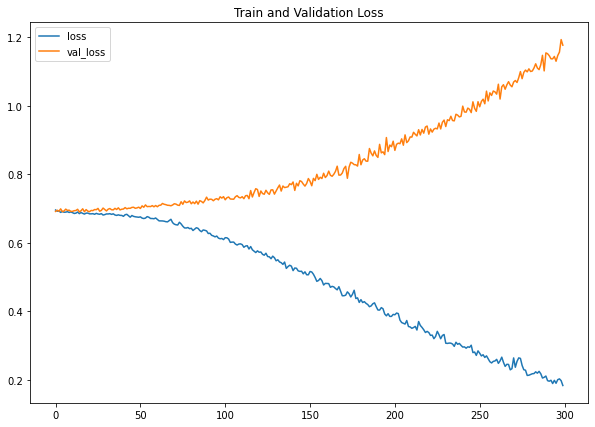

In [70]:
plt.figure(figsize = (10,7))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Train and Validation Loss")
plt.show()

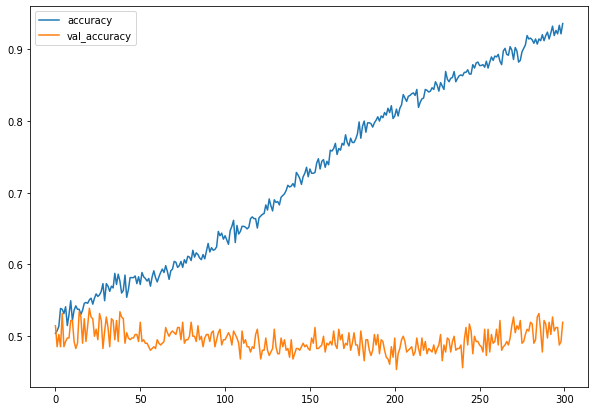

In [71]:
plt.figure(figsize=(10,7))
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### **Summary**:


1.   We saw that one-step ahead predictions are more accurate than the multi-step forecasts.
2.   Stock-price predictions can be modelled fairly accurately if we forecast only one-step ahead.
3.   Stock Returns cannot be modelled with good accuracy for both single-step and multi-step forecasts. 

